## 基于DenseNet121模型实现球类识别

该项目基于 DenseNet121 算法，实现球类运动识别，类别包括：棒球（baseball）、篮球（baseketball）、足球（football）、乒乓球（table tennis）和网球（tennis）。

### 环境准备

In [1]:
%%capture captured_output
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


### 超参设置

In [3]:
batch_size = 64  # 批量大小
image_size = 64  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 5  # 分类数量

### 数据集下载及数据处理

通过git下载魔乐平台的数据集。

In [4]:
!git lfs install
!git clone https://modelers.cn/xsir/scrence.git
!unzip -q scrence/dataset.zip -d ./scrence

Git LFS initialized.
正克隆到 'scrence'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 2), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (10/10), 完成.
处理 delta 中: 100% (2/2), 完成.


In [4]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore.common.initializer import Normal
import os
import time
# 数据集目录路径
data_path_train = "./scrence/dataset/train/"
data_path_val = "./scrence/dataset/val/"

# 创建训练数据集

def create_dataset_canidae(dataset_path, usage):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    scale = 32

    if usage == "train":
        # Define map operations for training dataset
        trans = [
            vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        # Define map operations for inference dataset
        trans = [
            vision.Decode(),
            vision.Resize(image_size + scale),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]


    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)


    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# 训练数据集中，前六张图片所对应的标签
print(f"Labels: {labels[:6]}")


# # 训练数据集的前六张图片
# plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     image_trans = np.transpose(images[i], (1, 2, 0))
#     mean = np.array([0.4914, 0.4822, 0.4465])
#     std = np.array([0.2023, 0.1994, 0.2010])
#     image_trans = std * image_trans + mean
#     image_trans = np.clip(image_trans, 0, 1)
#     plt.title(f"{classes[labels[i]]}")
#     plt.imshow(image_trans)
#     plt.axis("off")
# plt.show()

Image shape: (64, 3, 64, 64), Label shape: (64,)
Labels: [0 0 0 3 2 3]


## 模型初始化

In [6]:
"""
Initialize.
"""
import math
from functools import reduce
import numpy as np
import mindspore.nn as nn
from mindspore import Tensor
from mindspore.common import initializer as init

def _calculate_gain(nonlinearity, param=None):
    
    linear_fns = ['linear', 'conv1d', 'conv2d', 'conv3d', 'conv_transpose1d', 'conv_transpose2d', 'conv_transpose3d']
    if nonlinearity in linear_fns or nonlinearity == 'sigmoid':
        return 1
    if nonlinearity == 'tanh':
        return 5.0 / 3
    if nonlinearity == 'relu':
        return math.sqrt(2.0)
    if nonlinearity == 'leaky_relu':
        if param is None:
            negative_slope = 0.01
        elif not isinstance(param, bool) and isinstance(param, int) or isinstance(param, float):
            negative_slope = param
        else:
            raise ValueError("negative_slope {} not a valid number".format(param))
        return math.sqrt(2.0 / (1 + negative_slope ** 2))

    raise ValueError("Unsupported nonlinearity {}".format(nonlinearity))

def _assignment(arr, num):
    """Assign the value of `num` to `arr`."""
    if arr.shape == ():
        arr = arr.reshape((1))
        arr[:] = num
        arr = arr.reshape(())
    else:
        if isinstance(num, np.ndarray):
            arr[:] = num[:]
        else:
            arr[:] = num
    return arr

def _calculate_in_and_out(arr):
    
    dim = len(arr.shape)
    if dim < 2:
        raise ValueError("If initialize data with xavier uniform, the dimension of data must greater than 1.")

    n_in = arr.shape[1]
    n_out = arr.shape[0]

    if dim > 2:
        counter = reduce(lambda x, y: x * y, arr.shape[2:])
        n_in *= counter
        n_out *= counter
    return n_in, n_out

def _select_fan(array, mode):
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out']
    if mode not in valid_modes:
        raise ValueError("Mode {} not supported, please use one of {}".format(mode, valid_modes))

    fan_in, fan_out = _calculate_in_and_out(array)
    return fan_in if mode == 'fan_in' else fan_out

class KaimingInit(init.Initializer):
    
    def __init__(self, a=0, mode='fan_in', nonlinearity='leaky_relu'):
        super(KaimingInit, self).__init__()
        self.mode = mode
        self.gain = _calculate_gain(nonlinearity, a)

    def _initialize(self, arr):
        pass


class KaimingUniform(KaimingInit):

    def _initialize(self, arr):
        fan = _select_fan(arr, self.mode)
        bound = math.sqrt(3.0) * self.gain / math.sqrt(fan)
        data = np.random.uniform(-bound, bound, arr.shape)

        _assignment(arr, data)


class KaimingNormal(KaimingInit):

    def _initialize(self, arr):
        fan = _select_fan(arr, self.mode)
        std = self.gain / math.sqrt(fan)
        data = np.random.normal(0, std, arr.shape)

        _assignment(arr, data)


def default_recurisive_init(custom_cell):
    """default_recurisive_init"""
    for _, cell in custom_cell.cells_and_names():
        if isinstance(cell, nn.Conv2d):
            cell.weight.set_data(init.initializer(KaimingUniform(a=math.sqrt(5)), cell.weight.shape, cell.weight.dtype))
            if cell.bias is not None:
                fan_in, _ = _calculate_in_and_out(cell.weight.asnumpy())
                bound = 1 / math.sqrt(fan_in)
                cell.bias.set_data(Tensor(np.random.uniform(-bound, bound, cell.bias.shape), cell.bias.dtype))
        elif isinstance(cell, nn.Dense):
            cell.weight.set_data(init.initializer(KaimingUniform(a=math.sqrt(5)), cell.weight.shape, cell.weight.dtype))
            if cell.bias is not None:
                fan_in, _ = _calculate_in_and_out(cell.weight.asnumpy())
                bound = 1 / math.sqrt(fan_in)
                cell.bias.set_data(Tensor(np.random.uniform(-bound, bound, cell.bias.shape), cell.bias.dtype))
        elif isinstance(cell, (nn.BatchNorm2d, nn.BatchNorm1d)):
            pass


## DenseNet121模型

有关DenseNet121网络的详细情况可以参考论文https://arxiv.org/pdf/2406.15113

相比ResNet，DenseNet 提出了一个更激进的密集连接机制（Dense Connectivity），其核心思想是：网络中的每一层都与其前面的所有层直接相连。具体来说，每一层的输入不仅包括其前一层的输出，还包括之前所有层的输出作为额外的特征输入。这种设计通过显式地建立层与层之间的直接连接，极大地增强了特征传播和重用能力。

![](https://openi.pcl.ac.cn/attachments/c3db0ac1-00c1-42c6-8f7d-39324a080613?type=0)

在卷积神经网络（CNN）中，通常通过池化（Pooling）或步幅大于1的卷积（stride > 1 Conv）来逐步降低特征图的空间尺寸，从而减少计算复杂度并提取更高层次的语义信息。然而，DenseNet 的密集连接机制要求同一模块内的所有层具有相同的特征图大小，以便实现特征图的直接拼接和复用。为了解决这个问题，DenseNet 引入了 DenseBlock + Transition 的结构设计。

DenseBlock 是 DenseNet 的基本组成模块，由多个卷积层组成，每层的特征图大小保持一致。在DenseBlock 内部，每一层的输出都会与之前所有层的输出进行通道维度上的拼接（Concatenation），形成一个不断增长的特征集合。这种密集连接方式确保了特征的深度复用和高效传播。而 Transition 模块用于连接两个相邻的DenseBlock，并负责降低特征图的空间尺寸。通过这种方式，DenseNet 能够在保持密集连接优势的同时，逐步降低特征图的空间分辨率，提取更高层次的语义信息。

### 单个DenseBlock

![](https://openi.pcl.ac.cn/attachments/d5c3681b-de82-4ba4-8a86-54d67097f4ec?type=0)

让我们深入剖析密集块（DenseBlock）内部的运作机制，并以一种更直观的方式理解其工作原理。

假设我们有一个初始输入特征图（灰色），它被传递到第一层（LAYER_0）。
LAYER_0对输入特征图进行非线性变换（如卷积和激活函数），生成一组新的特征图（紫色）。这些新特征图与原始输入特征图在通道维度上拼接，形成一个新的特征集合（灰色 + 紫色）。
接下来，这个新的特征集合被传递到下一层（LAYER_1）。LAYER_1再次执行非线性变换，生成另一组新的特征图（橙色）。这些橙色特征图会与之前的特征集合（灰色 + 紫色）拼接，形成一个更大的特征集合（灰色 + 紫色 + 橙色）。
这个过程不断重复，直到密集块的最后一层。例如，在一个3层的密集块中，最终输出将是所有中间特征图的拼接结果（灰色 + 紫色 + 橙色 + 绿色）。
因此，在密集块中，每一层都会在其接收的现有特征图基础上生成一组新的特征图，并将它们拼接到全局特征集合中。
随着层数的增加，特征图的数量（即通道数）会逐步增长。这种增长是由每层新增的特征图数量决定的，而这一数量由“增长率”参数 K 控制。
参数 K 定义了每一层新增特征图的数量，是控制模型复杂度和特征多样性的关键超参数。通过调整 K，可以在模型性能和计算效率之间找到平衡点。

下图是DenseNet系列网络模型的结构：

![ ](https://openi.pcl.ac.cn/attachments/437bef81-7de0-4a25-8120-39d667f3bede?type=0)

DenseNet121 是 DenseNet 系列中的一种经典模型，其结构设计紧凑且高效，充分利用了密集块（DenseBlock）和过渡层（Transition Layer）的优势。其结构由初始卷积层、4 个密集块（分别包含 6、12、24 和 16 层卷积）以及过渡层交替堆叠而成，最后通过全局平均池化和全连接层完成分类任务。

相比于传统的卷积网络，DenseNet121 在参数效率和性能之间取得了良好的平衡，成为一种经典的深度学习模型。

In [7]:
import math
from collections import OrderedDict

import mindspore.nn as nn
from mindspore.ops import operations as P
from mindspore.common import initializer as init

class GlobalAvgPooling(nn.Cell):
    """
    GlobalAvgPooling function.
    """
    def __init__(self):
        super(GlobalAvgPooling, self).__init__()
        self.mean = P.ReduceMean(True)
        self.shape = P.Shape()
        self.reshape = P.Reshape()

    def construct(self, x):
        x = self.mean(x, (2, 3))
        b, c, _, _ = self.shape(x)
        x = self.reshape(x, (b, c))
        return x

class CommonHead(nn.Cell):
    def __init__(self, num_classes, out_channels):
        super(CommonHead, self).__init__()
        self.avgpool = GlobalAvgPooling()
        self.fc = nn.Dense(out_channels, num_classes, has_bias=True)

    def construct(self, x):
        x = self.avgpool(x)
        x = self.fc(x)
        return x

def conv7x7(in_channels, out_channels, stride=1, padding=3, has_bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=stride, has_bias=has_bias,
                     padding=padding, pad_mode="pad")


def conv3x3(in_channels, out_channels, stride=1, padding=1, has_bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, has_bias=has_bias,
                     padding=padding, pad_mode="pad")


def conv1x1(in_channels, out_channels, stride=1, padding=0, has_bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, has_bias=has_bias,
                     padding=padding, pad_mode="pad")


class _DenseLayer(nn.Cell):
    """
    the dense layer, include 2 conv layer
    """
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU()
        self.conv1 = conv1x1(num_input_features, bn_size*growth_rate)

        self.norm2 = nn.BatchNorm2d(bn_size*growth_rate)
        self.relu2 = nn.ReLU()
        self.conv2 = conv3x3(bn_size*growth_rate, growth_rate)

        # nn.Dropout in MindSpore use keep_prob, diff from Pytorch
        self.keep_prob = 1.0 - drop_rate
        self.dropout = nn.Dropout(p=1 - self.keep_prob)

    def construct(self, features):
        bottleneck = self.conv1(self.relu1(self.norm1(features)))
        new_features = self.conv2(self.relu2(self.norm2(bottleneck)))
        if self.keep_prob < 1:
            new_features = self.dropout(new_features)
        return new_features

class _DenseBlock(nn.Cell):
    """
    the dense block
    """
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.cell_list = nn.CellList()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.cell_list.append(layer)

        self.concate = P.Concat(axis=1)

    def construct(self, init_features):
        features = init_features
        for layer in self.cell_list:
            new_features = layer(features)
            features = self.concate((features, new_features))
        return features

class _Transition(nn.Cell):
    """
    the transition layer
    """
    def __init__(self, num_input_features, num_output_features, avgpool=False):
        super(_Transition, self).__init__()
        if avgpool:
            poollayer = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            poollayer = nn.MaxPool2d(kernel_size=2, stride=2)
        self.features = nn.SequentialCell(OrderedDict([
            ('norm', nn.BatchNorm2d(num_input_features)),
            ('relu', nn.ReLU()),
            ('conv', conv1x1(num_input_features, num_output_features)),
            ('pool', poollayer)
        ]))

    def construct(self, x):
        x = self.features(x)
        return x

class Densenet(nn.Cell):
    """
    the densenet architecture
    """
    __constants__ = ['features']

    def __init__(self, growth_rate, block_config, num_init_features=None, bn_size=4, drop_rate=0):
        super(Densenet, self).__init__()

        layers = OrderedDict()
        if num_init_features:
            layers['conv0'] = conv7x7(3, num_init_features, stride=2, padding=3)
            layers['norm0'] = nn.BatchNorm2d(num_init_features)
            layers['relu0'] = nn.ReLU()
            layers['pool0'] = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
            num_features = num_init_features
        else:
            layers['conv0'] = conv3x3(3, growth_rate*2, stride=1, padding=1)
            layers['norm0'] = nn.BatchNorm2d(growth_rate*2)
            layers['relu0'] = nn.ReLU()
            num_features = growth_rate * 2

        # Each denseblock
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate
            )
            layers['denseblock%d'%(i+1)] = block
            num_features = num_features + num_layers*growth_rate

            if i != len(block_config)-1:
                if num_init_features:
                    trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2,
                                        avgpool=False)
                else:
                    trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2,
                                        avgpool=True)
                layers['transition%d'%(i+1)] = trans
                num_features = num_features // 2

        # Final batch norm
        layers['norm5'] = nn.BatchNorm2d(num_features)
        layers['relu5'] = nn.ReLU()

        self.features = nn.SequentialCell(layers)
        self.out_channels = num_features

    def construct(self, x):
        x = self.features(x)
        return x

    def get_out_channels(self):
        return self.out_channels


def _densenet121(**kwargs):

    return Densenet(growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, **kwargs)

class DenseNet121(nn.Cell):
    """
    the densenet121 architecture
    """
    def __init__(self, num_classes, include_top=True):
        super(DenseNet121, self).__init__()
        self.backbone = _densenet121()
        out_channels = self.backbone.get_out_channels()
        self.include_top = include_top
        if self.include_top:
            self.head = CommonHead(num_classes, out_channels)

        default_recurisive_init(self)
        for _, cell in self.cells_and_names():
            if isinstance(cell, nn.Conv2d):
                cell.weight.set_data(init.initializer(KaimingNormal(a=math.sqrt(5), mode='fan_out',
                                                                    nonlinearity='relu'),
                                                      cell.weight.shape,
                                                      cell.weight.dtype))
            elif isinstance(cell, nn.BatchNorm2d):
                cell.gamma.set_data(init.initializer('ones', cell.gamma.shape))
                cell.beta.set_data(init.initializer('zeros', cell.beta.shape))
            elif isinstance(cell, nn.Dense):
                cell.bias.set_data(init.initializer('zeros', cell.bias.shape))

    def construct(self, x):
        x = self.backbone(x)
        if not self.include_top:
            return x
        x = self.head(x)
        return x


### 模型训练
跑了50epochs训练结果如下:

In [8]:
network = DenseNet121(num_classes=5)

In [9]:
# 设置学习率
num_epochs = 50
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

In [10]:
import os

# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/densenet121-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)

In [11]:
import mindspore.ops as ops


def train(data_loader, epoch):
    """模型训练"""
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """模型验证"""
    network.set_train(False)

    correct_num = 0.0  # 预测正确个数
    total_num = 0.0  # 预测总数

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # 预测结果
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # 准确率

    return acc

In [12]:
# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)
    if (epoch + 1) % 10 == 0:
        print("-" * 50)
        print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
            epoch+1, num_epochs, curr_loss, curr_acc
        ))

    # 保存当前预测准确率最高的模型
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
....--------------------------------------------------
Epoch: [ 10/ 50], Average Train Loss: [1.403], Accuracy: [0.400]
--------------------------------------------------
Epoch: [ 20/ 50], Average Train Loss: [1.292], Accuracy: [0.520]
--------------------------------------------------
Epoch: [ 30/ 50], Average Train Loss: [1.240], Accuracy: [0.560]
--------------------------------------------------
Epoch: [ 40/ 50], Average Train Loss: [1.182], Accuracy: [0.520]
--------------------------------------------------
Epoch: [ 50/ 50], Average Train Loss: [1.189], Accuracy: [0.520]
End of validation the best Accuracy is:  0.640, save the best ckpt file in ./BestCheckpoint/densenet121-best.ckpt


### 可视化模型预测
定义`visualize_model`函数，使用上述验证精度最高的模型对测试数据集进行预测，并将预测结果可视化。若预测字体颜色为蓝色表示为预测正确，预测字体颜色为红色则表示预测错误。

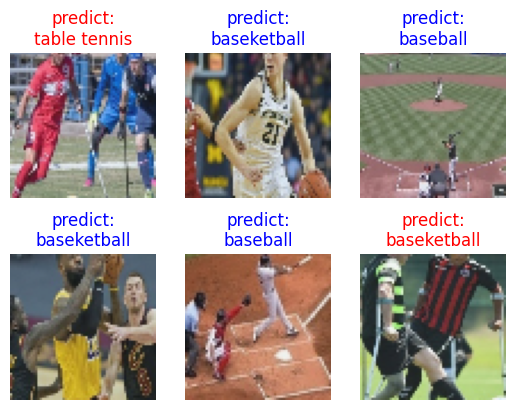

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_model(best_ckpt_path, dataset_val):
    net = DenseNet121(num_classes=5)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    # 预测图像类别
    output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # 图像分类
    classes = ["baseball", "baseketball", "football", "table tennis", "tennis"]

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('predict:\n{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)